[*********************100%***********************]  1 of 1 completed


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


SVR MSE: 29.2880
Random Forest MSE: 338.9554
XGBoost MSE: 416.1911


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
LSTM MSE: 33058.2096

 Model Comparison:
SVR: MSE = 29.2880
Random Forest: MSE = 338.9554
XGBoost: MSE = 416.1911
LSTM: MSE = 33058.2096

 Best performing model based on MSE: SVR


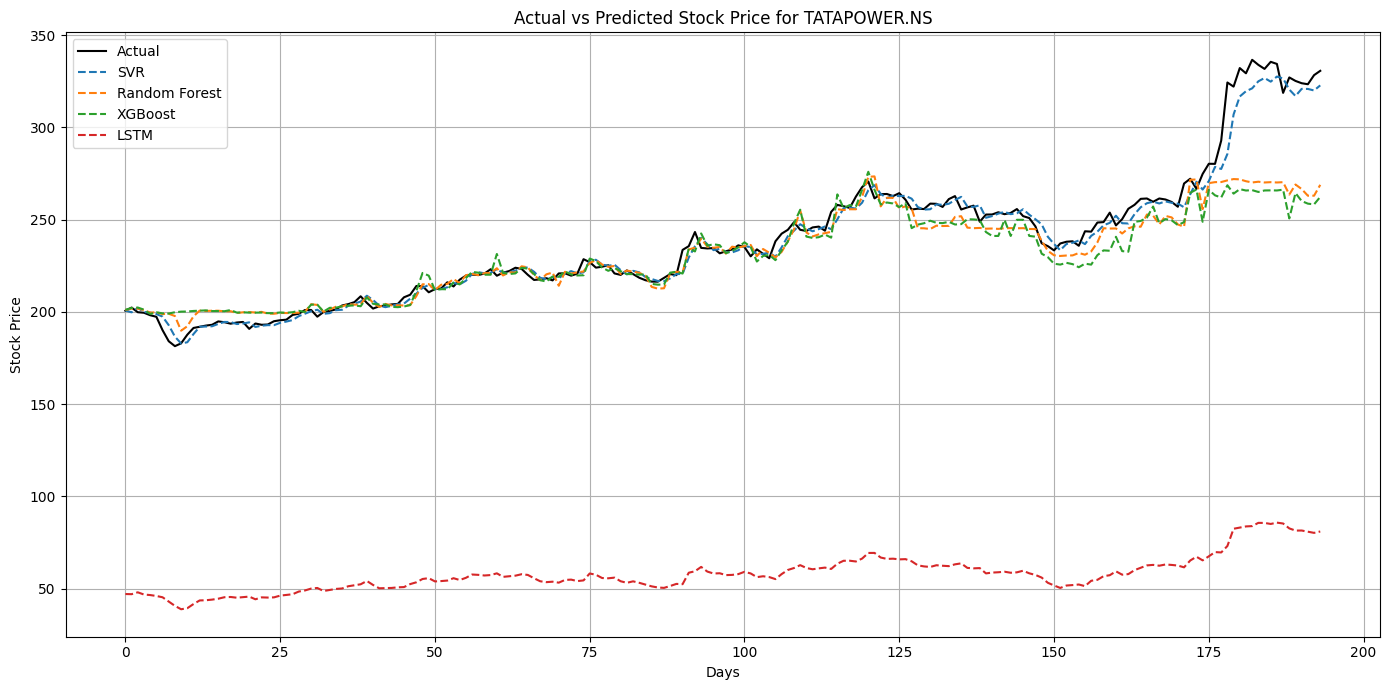

In [6]:
# Stock Price Prediction

# --- 1. Imports ---
!pip install ta
import ta
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time

# --- 2. Configuration ---
TICKER = "TATAPOWER.NS"
START_DATE = "2020-01-01"
END_DATE = "2024-01-01"
RPM_LIMIT = 7  # To avoid hitting API limits

# --- 3. Download Stock Data ---
stock_data = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", auto_adjust=True)
time.sleep(60 / RPM_LIMIT)  # Respect API limits

# --- 4. Preprocess Data ---
!pip install nltk vaderSentiment
import nltk
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

# Dummy sentiment analysis: replace this with real news headline API and timestamps if available
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []

for date in stock_data.index:
    dummy_headline = f"Stock movement on {date.date()}"
    sentiment = analyzer.polarity_scores(dummy_headline)['compound']
    sentiment_scores.append(sentiment)

stock_data['Sentiment'] = sentiment_scores

from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator

# Calculate technical indicators (pass Series directly)
stock_data['RSI'] = RSIIndicator(close=stock_data['Close'].squeeze(), window=14).rsi()
stock_data['SMA_20'] = SMAIndicator(close=stock_data['Close'].squeeze(), window=20).sma_indicator()
stock_data['MACD'] = MACD(close=stock_data['Close'].squeeze()).macd()

# Drop rows with NaNs due to indicator calculation
stock_data.dropna(inplace=True)
stock_data["Target"] = stock_data["Close"].shift(-1)  # Predict next day's close
stock_data.dropna(inplace=True)

features = ["Open", "High", "Low", "Close", "Volume", "RSI", "SMA_20", "MACD", "Sentiment"]
X = stock_data[features]
y = stock_data["Target"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

# --- 6. SVR Model ---
svr_model = SVR(kernel='rbf', C=1000, gamma=0.01, epsilon=0.01)
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {svr_mse:.4f}")

# --- 7. Random Forest Regressor ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {rf_mse:.4f}")

# --- 8. XGBoost Regressor ---
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {xgb_mse:.4f}")

# --- 9. LSTM Model ---
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM MSE: {lstm_mse:.4f}")

# --- 10. Model Comparison ---
model_mse = {
    'SVR': svr_mse,
    'Random Forest': rf_mse,
    'XGBoost': xgb_mse,
    'LSTM': lstm_mse
}

best_model = min(model_mse, key=model_mse.get)
print("\n Model Comparison:")
for name, mse in model_mse.items():
    print(f"{name}: MSE = {mse:.4f}")
print(f"\n Best performing model based on MSE: {best_model}")

# --- 11. Visualization ---
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_svr, label='SVR', linestyle='dashed')
plt.plot(y_pred_rf, label='Random Forest', linestyle='dashed')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='dashed')
plt.plot(y_pred_lstm, label='LSTM', linestyle='dashed')
plt.title(f"Actual vs Predicted Stock Price for {TICKER}")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




 Model Comparison:
SVR: MSE = 29.2880
Random Forest: MSE = 338.9554
XGBoost: MSE = 416.1911
LSTM: MSE = 33058.2096

 Best performing model based on MSE: SVR


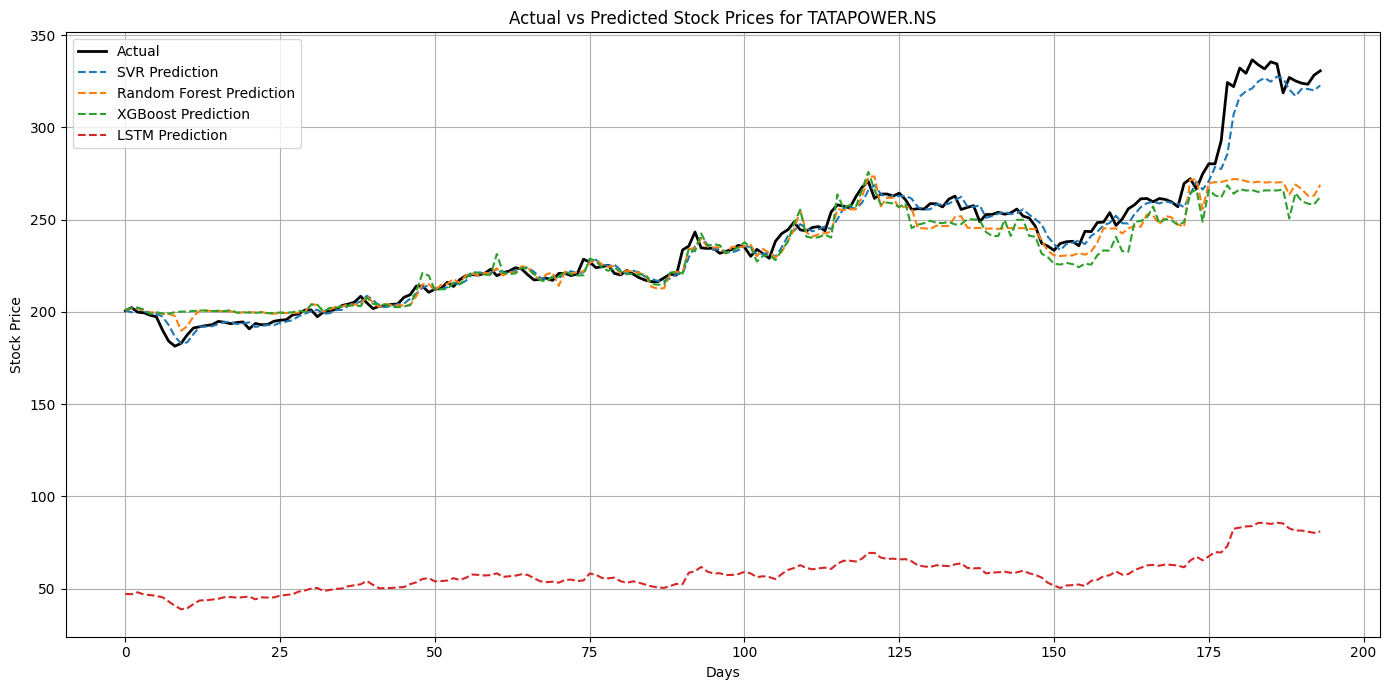

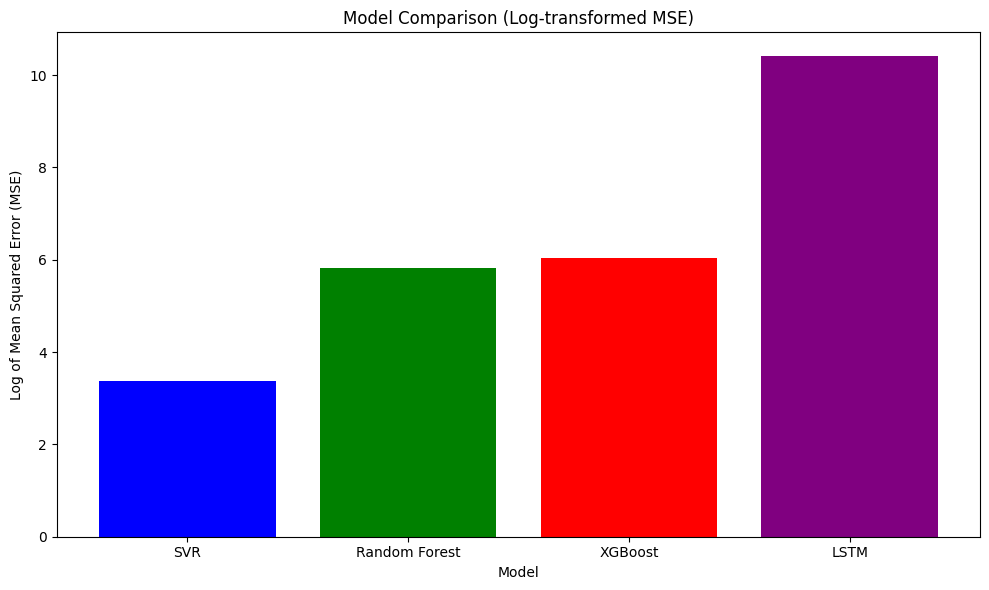

In [11]:
# --- 10. Model Comparison ---

# Create a dictionary to store predictions for each model
predictions = {
    'SVR': y_pred_svr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LSTM': y_pred_lstm
}

# Create a dictionary to store MSE for each model
model_mse = {
    'SVR': svr_mse,
    'Random Forest': rf_mse,
    'XGBoost': xgb_mse,
    'LSTM': lstm_mse
}

# Print the MSE for each model
print("\n Model Comparison:")
for name, mse in model_mse.items():
    print(f"{name}: MSE = {mse:.4f}")

# Determine the best model based on MSE
best_model = min(model_mse, key=model_mse.get)
print(f"\n Best performing model based on MSE: {best_model}")

# --- 11. Visual Comparison of Model Predictions ---

# Plot the actual vs predicted stock prices for all models
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)

# Loop through the predictions and plot each model's prediction
for model_name, prediction in predictions.items():
    plt.plot(prediction, label=f'{model_name} Prediction', linestyle='--')

plt.title(f"Actual vs Predicted Stock Prices for {TICKER}")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np

# --- 12. Model Performance Bar Plot with Log Scale ---
# Apply log transformation to the MSE values to make the chart more visually comparable
log_model_mse = {model: np.log(mse + 1e-6) for model, mse in model_mse.items()}

# Plot the MSE comparison as a bar chart for easy visual comparison with logarithmic scale
plt.figure(figsize=(10, 6))
plt.bar(log_model_mse.keys(), log_model_mse.values(), color=['blue', 'green', 'red', 'purple'])
plt.title("Model Comparison (Log-transformed MSE)")
plt.xlabel("Model")
plt.ylabel("Log of Mean Squared Error (MSE)")
plt.tight_layout()
plt.show()

# --- 13. Model Comparison with Percentage of Best Model's MSE ---
# Normalize the MSEs to show how each model performs relative to the best model
best_mse = min(model_mse.values())
normalized_mse = {model: (mse / best_mse) * 100 for model, mse in model_mse.items()}



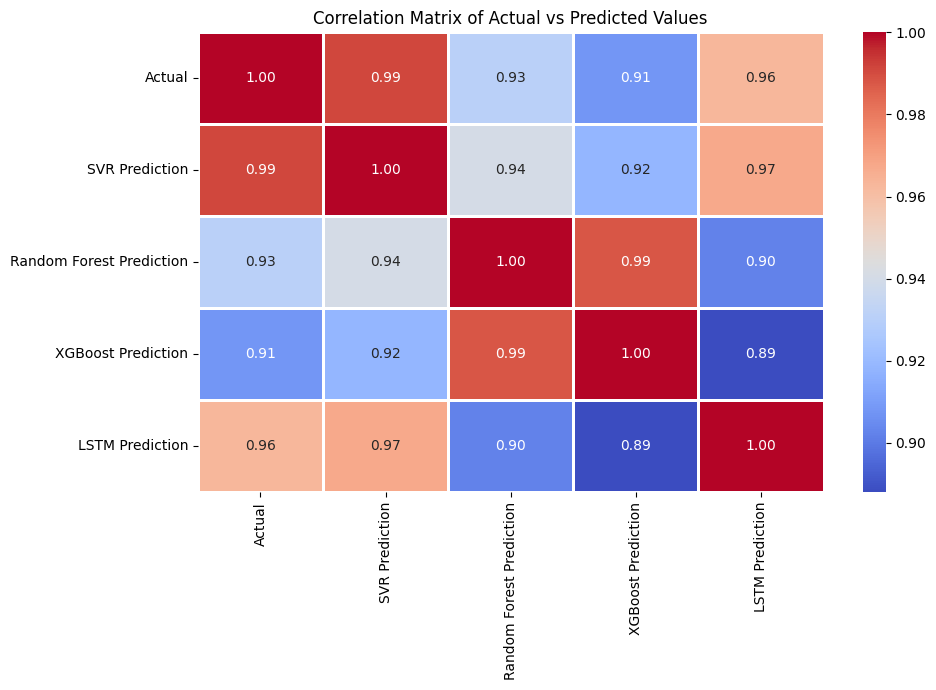

In [13]:
import seaborn as sns

# Combine actual and predicted values into one DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'SVR Prediction': y_pred_svr,
    'Random Forest Prediction': y_pred_rf,
    'XGBoost Prediction': y_pred_xgb,
    'LSTM Prediction': y_pred_lstm
})

# Calculate the correlation matrix
correlation_matrix = comparison_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Matrix of Actual vs Predicted Values')
plt.tight_layout()
plt.show()

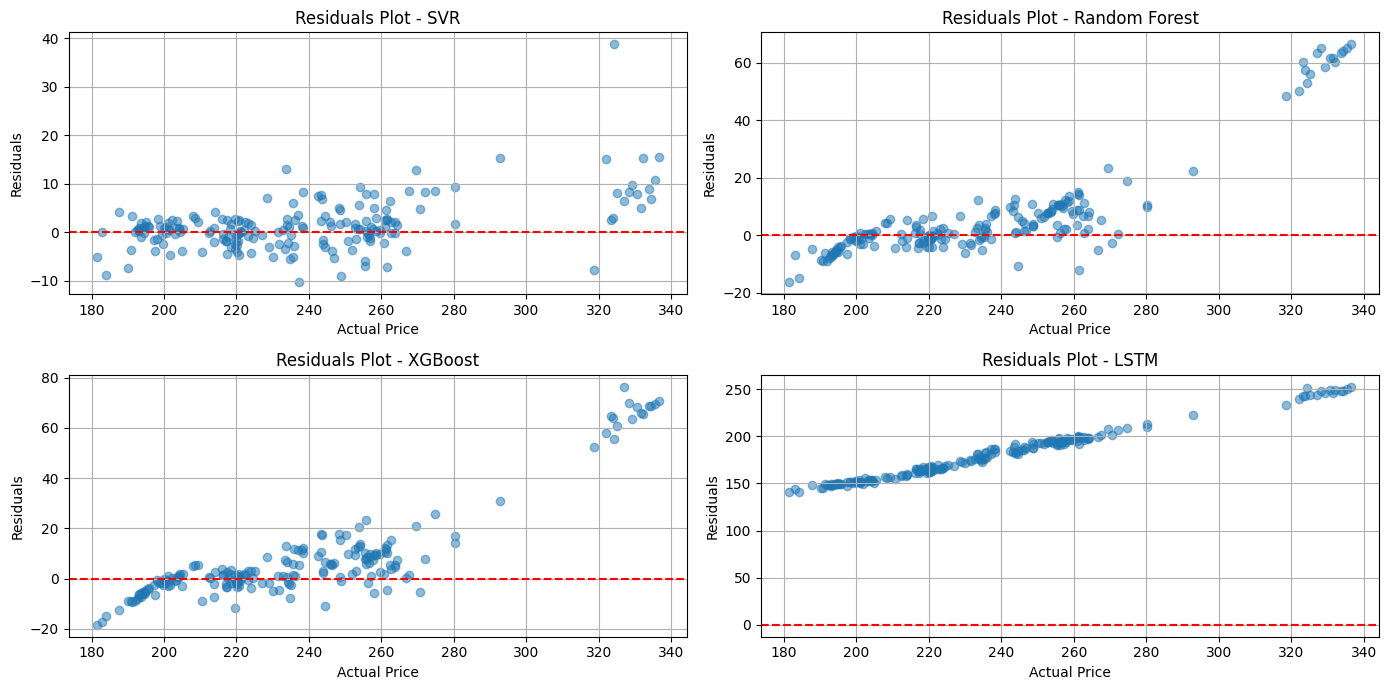

In [12]:
# Plot residuals (difference between actual and predicted values) for each model
plt.figure(figsize=(14, 7))

models = ['SVR', 'Random Forest', 'XGBoost', 'LSTM']
predictions_list = [y_pred_svr, y_pred_rf, y_pred_xgb, y_pred_lstm]

for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    residuals = y_test.values - predictions_list[i]
    plt.scatter(y_test.values, residuals, label=model, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residuals Plot - {model}')
    plt.xlabel('Actual Price')
    plt.ylabel('Residuals')
    plt.grid(True)

plt.tight_layout()
plt.show()